# Gene Expression

---
author: Alex Kim
date: October 30, 2024
embed-resources: true
---

## Introduction

Cancer screening, also known as cancer detection, is an universally important part of life for anyone. The main objective of cancer screening is to detect cancer before symptoms occur. Detecting cancer earlier could significantly improve one's chances of survival. The use of genetic information to push detection earlier is one method that has been studied extensively. One straightforward genetic test that can be used to more accurately predict the risk of developing breast cancer is the BRCA mutation. Gene expression can provide information on how DNA influences phenotypic outcomes downstream of DNA itself. Gene expression can be measured using a rapidly developing set of technologies called next-generation sequencing. As these technologies become more and more accessible and affordable, they may be incorporated into the process for detecting and diagnosing cancers.

As a data scientist, who works for a small biotechnology startup company, I am tasked to develop a “universal” cancer detection and classification model, given gene expression data collected from a next-generation sequencing like RNA-Seq. My primary goal is to develop a model or product that would be helpful in verifying that the concept of a universal cure for cancer has practical potential.

## Methods

In [4]:
# general imports
import pandas as pd
import seaborn as sns 
import numpy as np

# plot & visualizations
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# model tuning and preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# model metrics
from sklearn.metrics import accuracy_score

from sklearn.ensemble import HistGradientBoostingClassifier

To successfully develop a cancer detection and classification model, I will be using collected data from The Cancer Genome Atlas Pan-Cancer Analysis Project, which was accessed through synapse.org. The specific dataset that will be used for developing the model was modified and collected from UCI MLR: Gene Expression Cancer RNA-Seq, which was accessed through UC Irvine Mahcine Learning Repository.

### Data Dictionary

#### Response
* **Cancer** [object]: the clinically determined cancer type, one of:
    * BRCA: Breast Invasive Carcinoma
    * PRAD: Prostate Adenocarcinoma
    * KIRC: Kidney Renal Clear Cell Carcinoma
    * LUAD: Lung Adenocarcinoma
    * COAD: Colon Adenocarcinoma

#### Feature
* **gene_** [float64]: gene expression quantification as measured by an Illumina HiSeq platform

### Data

In [5]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


The train dataset contains 128 rows and 2001 columns. This tells us that there are 128 samples and 2000 features.

In [6]:
# summary statistics
cancer_train.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,128.0,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.026605,3.091910,3.173587,6.756002,9.758675,0.0,7.509732,0.541809,0.021281,0.0,...,6.912019,8.813432,6.013760,0.114844,7.848970,0.080967,5.753696,5.690223,8.657299,0.611906
std,0.123771,1.208050,1.012525,0.656548,0.433552,0.0,1.064819,0.536572,0.168834,0.0,...,0.586217,0.653409,3.412418,0.264236,0.562358,0.273796,1.076972,0.716395,0.665498,0.937252
min,0.000000,0.000000,0.836974,5.411196,8.435999,0.0,4.302421,0.000000,0.000000,0.0,...,5.556632,7.603315,0.000000,0.000000,6.684216,0.000000,3.348672,3.838841,4.811759,0.000000
25%,0.000000,2.318692,2.539053,6.403882,9.458238,0.0,6.865693,0.000000,0.000000,0.0,...,6.555507,8.344798,3.325768,0.000000,7.389345,0.000000,5.021869,5.214861,8.287765,0.000000
50%,0.000000,3.304315,3.266389,6.673828,9.767547,0.0,7.565710,0.487228,0.000000,0.0,...,6.921816,8.769753,5.117962,0.000000,7.832738,0.000000,5.614630,5.673441,8.654792,0.000000
75%,0.000000,3.933405,3.837908,7.029259,10.048417,0.0,8.185798,0.907964,0.000000,0.0,...,7.331416,9.222378,8.339959,0.000000,8.247489,0.000000,6.436439,6.253795,9.092482,0.980663
max,0.757450,6.237034,6.063484,10.129528,11.151461,0.0,10.089609,1.974419,1.785592,0.0,...,8.119673,10.573458,13.809095,1.253324,9.183740,1.936779,8.413903,7.418983,10.230549,5.152569


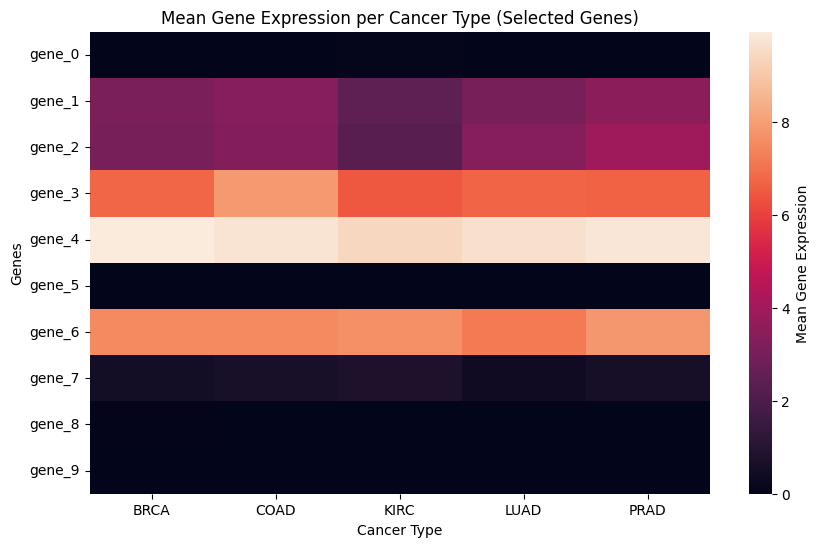

In [19]:
# visualizations
# Select specific genes to visualize 
selected_genes = ['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4','gene_5','gene_6','gene_7','gene_8','gene_9']
cancer_subset = cancer_train[['cancer'] + selected_genes]

# Group by cancer type and calculate the mean gene expression for each type
gene_expression_mean = cancer_subset.groupby("cancer").mean()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gene_expression_mean[selected_genes].T, cbar_kws={'label': 'Mean Gene Expression'})
plt.title("Mean Gene Expression per Cancer Type (Selected Genes)")
plt.xlabel("Cancer Type")
plt.ylabel("Genes")
plt.show()

The heatmap plot above shows how different genes are expressed across various types of cancer. This plot allows us to observe and compare gene expression levels for a specifically selected genes across different cancer types, such as BRCA, PRAD, KIRC, LUAD, COAD. From this plot, we can also clearly tell and identify patterns such as which genes have higher or lower mean expression in a specific cancer type. The heatmap  highlights specific genes associated with a certain cancer type through different color shades, which helps us identify potential biological indicator that can be measured/evaluated to provide information about the progression or presence of different types of cancers. Finding the biological indicator could ultimately be useful for treatments for cancers.

### Models

In [31]:
# process data for ML
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]

In [32]:
# train models

# note numeric and categorical features
numeric_features = cancer_train.iloc[:, 1:]
categorical_features = ['cancer']

# define pipeline for numeric
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)

# define preprocessing pipeline for categorical
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("CategoricalPreprocessing", categorical_preprocessor, categorical_features),
        ("NumericProcessing", numeric_preprocessor, numeric_features),
    ],
    remainder="drop",
)

# create pipeline
pipeline = Pipeline(
    steps=[
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42),
        ),
    ]
)

HistGradientBoostingClassifier().get_params()

# define parameter grid
param_grid = {
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5],
    "classifier__max_iter": [100, 200],
    "classifier__max_features": [0.1, 0.25, 0.5, 0.75, 1.0]
}

In [33]:
# setup grid search with cross-validation
mod = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
)

In [34]:
mod.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1, 0.25,
                                                       0.5],
                         'classifier__max_features': [0.1, 0.25, 0.5, 0.75,
                                                      1.0],
                         'classifier__max_iter': [100, 200]},
             scoring='accuracy', verbose=1)

In [35]:
mod.best_estimator_

Pipeline(steps=[('classifier',
                 HistGradientBoostingClassifier(learning_rate=0.05,
                                                max_features=0.1,
                                                random_state=42))])

In [36]:
# inspect (first 10) estimated conditional probabilities in test data
mod.predict_proba(X_test)[:10]

array([[2.37049544e-03, 1.45220566e-04, 1.80613399e-04, 9.96458913e-01,
        8.44757142e-04],
       [9.99777485e-01, 1.04357454e-05, 1.95105254e-05, 1.66631168e-04,
        2.59376870e-05],
       [1.20438826e-04, 1.49889422e-05, 9.99726991e-01, 1.04718393e-04,
        3.28629292e-05],
       [1.10476303e-04, 1.90383873e-04, 9.99471934e-01, 1.77199837e-04,
        5.00061253e-05],
       [1.09411804e-03, 1.07605985e-04, 5.63706064e-05, 2.26447177e-04,
        9.98515458e-01],
       [4.65286195e-04, 9.98588641e-01, 4.75493010e-05, 8.21555660e-04,
        7.69680560e-05],
       [4.11843531e-04, 4.81356210e-05, 6.70362187e-05, 1.16560363e-03,
        9.98307381e-01],
       [5.27486584e-04, 1.55695008e-04, 7.31693206e-05, 4.80332235e-04,
        9.98763317e-01],
       [1.10920875e-04, 8.35390267e-06, 1.37956501e-05, 4.80600789e-05,
        9.99818869e-01],
       [2.67788773e-04, 1.57854865e-05, 1.66715438e-05, 8.81493901e-05,
        9.99611605e-01]])

## Results

In [37]:
# report model metrics

y_pred = mod.predict(X_test)

# evaluate and print test metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")
print("Best parameters:", mod.best_params_)

Test accuracy: 1.0000
Best parameters: {'classifier__learning_rate': 0.05, 'classifier__max_features': 0.1, 'classifier__max_iter': 100}


The classification model achieves a test accuracy of 1.000. 

## Discussion

Assuming you develop a promising model (which is likely), what next steps would you take to further investigate the possibility of a universal cancer detector and classifier?

Through the development process of the model that detects and classifies cancer, I developed a model that achieves a test accuracy of 1.000 and production accuracy of 0.99. This accuracy score tells us that this model is likely a very promising classification model for detecting cancer. The next steps I would take to further investigate the possibility of a universal cancer detector and classifier would obviously be further improving and testing the model in an even broader range of contexts. This way, I would be able to thoroughly assess the practicability of the model in a real world context. To improve the model's performance on any or most real-world scenarios, I would test the model out across wide range of demographic population. This would ensure that the model would correctly identify or detect cancer in people with various genetic backgrounds. Another approach that can be taken to further refine the model would be to including additional factors like family history and background, prior medical records, daily lifestyle patterns, and more would provide a more extensive and complete prediction in classifying or detecting cancer. To directly test out the model's effectiveness, it can be put into practice by monitoring people over time to observe whether gene expression data can identify early cancer stages. This approach would help the model's early detection potential validation.

### Conclusion

Overall, the model definitely is promising in that it brings about accurate classification results, achieving a 100% test accuracy. However, I would not use the model in practice without further improvements or refinements. Perfect accuracy could often be a sign of overfitting as the test and training datasets may not be accurately reflective of real-world situations. A 100% accuracy may indicate that the model is specifically trained to our selected dataset, but can not be generalizable to other datasets. To guarntee reliability, I would carry out more testing with additional datasets and cross-validation.